In [384]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import joblib

In [385]:
data = yf.Ticker("AAPL")

In [386]:
data = data.history(period="max")
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.099058,0.099488,0.099058,0.099058,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.094321,0.094321,0.093890,0.093890,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.087429,0.087429,0.086998,0.086998,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.089152,0.089582,0.089152,0.089152,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.091737,0.092167,0.091737,0.091737,73449600,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-30 00:00:00-04:00,190.759995,192.179993,190.630005,191.289993,49947900,0.0,0.0
2024-05-31 00:00:00-04:00,191.440002,192.570007,189.910004,192.250000,75158300,0.0,0.0
2024-06-03 00:00:00-04:00,192.899994,194.990005,192.520004,194.029999,50080500,0.0,0.0


<Axes: xlabel='Date'>

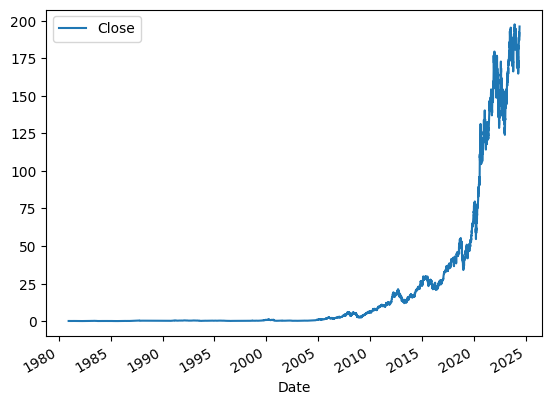

In [387]:
data.plot(y="Close")

In [388]:
del data["Dividends"]
del data["Stock Splits"]

<Axes: xlabel='Date'>

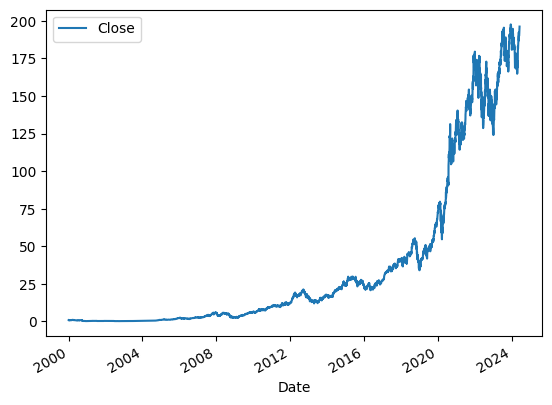

In [389]:
data["Tomorrow"] = data["Close"].shift(-1)
data = data.loc["1996-01-01":]
data.plot(y="Close")

In [390]:
data["Target"] = (data["Tomorrow"] > data["Close"]).astype(int)
data

C:\Users\huber\AppData\Local\Temp\ipykernel_26180\2033468594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Target"] = (data["Tomorrow"] > data["Close"]).astype(int)


,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2000-01-03 00:00:00-05:00,0.791668,0.849227,0.767607,0.844981,535796800,0.773741,0
2000-01-04 00:00:00-05:00,0.817145,0.835073,0.763833,0.773741,512377600,0.785063,1
2000-01-05 00:00:00-05:00,0.783176,0.834601,0.777515,0.785063,778321600,0.717125,0
2000-01-06 00:00:00-05:00,0.801104,0.807709,0.717125,0.717125,767972800,0.751094,1
2000-01-07 00:00:00-05:00,0.728448,0.762418,0.720900,0.751094,460734400,0.737884,0
...,...,...,...,...,...,...,...
2024-05-30 00:00:00-04:00,190.759995,192.179993,190.630005,191.289993,49947900,192.250000,1
2024-05-31 00:00:00-04:00,191.440002,192.570007,189.910004,192.250000,75158300,194.029999,1
2024-06-03 00:00:00-04:00,192.899994,194.990005,192.520004,194.029999,50080500,194.350006,1


In [391]:
predictors = ["Open", "High", "Low", "Close", "Volume"]

In [392]:
def compute_ratio(data, window):
    return data['Close'] / data['Close'].rolling(window=window).mean()

def compute_trend(data, window):
    return data["Target"].shift(1).rolling(window=window).sum()

def compute_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_sma(data, window):
    return data['Close'].rolling(window=window).mean()

def compute_ema(data, window):
    return data['Close'].ewm(span=window, adjust=False).mean()

def compute_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

In [393]:
windows = [2, 5, 10, 50, 100, 300, 500, 1000]

for window in windows:
    ratio_column = f"Close_Ratio_{window}"
    trend_column = f"Trend_{window}"
    rsi_column = f"RSI_{window}"
    sma_column = f"SMA_{window}"
    ema_column = f"EMA_{window}"
    macd_column = f"MACD_{window}"
    signal_column = f"Signal_{window}"
    data.loc[:, ratio_column] = compute_ratio(data, window)
    data.loc[:, trend_column] = compute_trend(data, window)
    data.loc[:, rsi_column] = compute_rsi(data, window)
    data.loc[:, sma_column] = compute_sma(data, window)
    data.loc[:, ema_column] = compute_ema(data, window)
    data.loc[:, macd_column], data.loc[:, signal_column] = compute_macd(data, window, window * 2, int(window * 1.5))
    predictors += [ratio_column, trend_column, rsi_column, sma_column, ema_column, macd_column, signal_column]

C:\Users\huber\AppData\Local\Temp\ipykernel_26180\96380091.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[ratio_column] = compute_ratio(data, horizon)
C:\Users\huber\AppData\Local\Temp\ipykernel_26180\96380091.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[trend_column] = compute_trend(data, horizon)
C:\Users\huber\AppData\Local\Temp\ipykernel_26180\96380091.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [394]:
data = data.dropna()
data

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,RSI_2,...,EMA_500,MACD_500,Signal_500,Close_Ratio_1000,Trend_1000,RSI_1000,SMA_1000,EMA_1000,MACD_1000,Signal_1000
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-26 00:00:00-05:00,0.307232,0.315686,0.307080,0.313723,103695200,0.319310,1,1.008983,2.0,100.0,...,0.309149,-0.086855,-0.101268,0.801992,471.0,47.762378,0.391180,0.396004,-0.138064,-0.077353
2003-12-29 00:00:00-05:00,0.315686,0.319460,0.314931,0.319310,233458400,0.321272,1,1.008825,2.0,100.0,...,0.309189,-0.086661,-0.101229,0.817223,472.0,48.075324,0.390725,0.395851,-0.138003,-0.077434
2003-12-30 00:00:00-05:00,0.319762,0.324594,0.319310,0.321272,204853600,0.322631,1,1.003063,2.0,100.0,...,0.309237,-0.086464,-0.101189,0.823222,472.0,48.034123,0.390262,0.395702,-0.137940,-0.077515
2003-12-31 00:00:00-05:00,0.322329,0.325046,0.319762,0.322631,174451200,0.321272,0,1.002110,2.0,100.0,...,0.309291,-0.086265,-0.101150,0.827540,473.0,48.318360,0.389867,0.395556,-0.137875,-0.077595
2004-01-02 00:00:00-05:00,0.325348,0.328368,0.319762,0.321272,144642400,0.334709,1,0.997890,1.0,50.0,...,0.309339,-0.086068,-0.101110,0.824965,472.0,48.162656,0.389437,0.395407,-0.137811,-0.077675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-29 00:00:00-04:00,189.610001,192.250000,189.509995,190.289993,53068000,191.289993,1,1.000789,2.0,100.0,...,168.052109,21.430202,21.566052,1.263976,521.0,52.754606,150.548722,146.621907,34.250226,22.921460
2024-05-30 00:00:00-04:00,190.759995,192.179993,190.630005,191.289993,49947900,192.250000,1,1.002621,2.0,100.0,...,168.144875,21.433721,21.565700,1.269714,521.0,52.717020,150.656025,146.711154,34.260594,22.936569
2024-05-31 00:00:00-04:00,191.440002,192.570007,189.910004,192.250000,75158300,194.029999,1,1.002503,2.0,100.0,...,168.241104,21.438963,21.565362,1.275188,521.0,52.688250,150.762128,146.802141,34.271822,22.951672


In [395]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

X_train, y_train = train_data[predictors], train_data["Target"]
X_test, y_test = test_data[predictors], test_data["Target"]

In [396]:
tscv = TimeSeriesSplit(n_splits=5)
ada_model = AdaBoostClassifier(random_state=1, algorithm='SAMME')
param_grid_ada = {
    'n_estimators': [100, 300, 500, 1000, 2000],
    'learning_rate': [0.01, 0.1, 0.2, 0.5]
}


grid_search_ada = GridSearchCV(estimator=ada_model, param_grid=param_grid_ada, cv=tscv, n_jobs=-1, verbose=2, scoring='precision')
grid_search_ada.fit(X_train, y_train)

best_params_ada = grid_search_ada.best_params_
ada_model.set_params(**best_params_ada)
print(best_params_ada)

ada_model.fit(X_train, y_train)

ada_test_preds  = ada_model.predict(X_test)
print('Test Precision score: ', precision_score(y_test, ada_test_preds))
print('Test Accuracy score: ', accuracy_score(y_test, ada_test_preds))
print('Test Recall score: ', recall_score(y_test, ada_test_preds))
print('Test F1 score: ', f1_score(y_test, ada_test_preds))

joblib.dump(ada_model, 'ada_model.joblib')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\huber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'learning_rate': 0.01, 'n_estimators': 100}


c:\Users\huber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Test Precision score:  0.5263671875
Test Accuracy score:  0.5257531584062196
Test Recall score:  0.9944649446494465
Test F1 score:  0.6883780332056194


In [397]:
rf_model = RandomForestClassifier(random_state=1)
param_grid_rf = {
    'n_estimators': [100, 300, 500, 1000, 2000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20, 50, 100]
}

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=tscv, n_jobs=-1, verbose=2, scoring='precision')
grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
print(best_params_rf)

rf_model.set_params(**best_params_rf)
rf_model.fit(X_train, y_train)

rf_test_preds  = rf_model.predict(X_test)
print('Test Precision score: ', precision_score(y_test, rf_test_preds))
print('Test Accuracy score: ', accuracy_score(y_test, rf_test_preds))
print('Test Recall score: ', recall_score(y_test, rf_test_preds))
print('Test F1 score: ', f1_score(y_test, rf_test_preds))

joblib.dump(rf_model, 'rf_model.joblib')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'max_depth': 20, 'min_samples_split': 50, 'n_estimators': 100}
Test Precision score:  0.5384615384615384
Test Accuracy score:  0.48299319727891155
Test Recall score:  0.12915129151291513
Test F1 score:  0.20833333333333334


In [398]:
xgb_model = XGBClassifier(random_state=1)
param_grid_xgb = {
    'n_estimators': [100, 300, 500, 1000, 2000],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [3, 5, 7, 10]
}

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=tscv, n_jobs=-1, verbose=2, scoring='precision')
grid_search_xgb.fit(X_train, y_train)

best_params_xgb = grid_search_xgb.best_params_
print(best_params_xgb)

xgb_model.set_params(**best_params_xgb)
xgb_model.fit(X_train, y_train)

test_preds_xgb = xgb_model.predict(X_test)
print('Test Precision score: ', precision_score(y_test, test_preds_xgb))
print('Test Accuracy score: ', accuracy_score(y_test, test_preds_xgb))
print('Test Recall score: ', recall_score(y_test, test_preds_xgb))
print('Test F1 score: ', f1_score(y_test, test_preds_xgb))

joblib.dump(xgb_model, 'xgb_model.joblib')

Fitting 5 folds for each of 80 candidates, totalling 400 fits
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Test Precision score:  0.5313751668891856
Test Accuracy score:  0.5189504373177842
Test Recall score:  0.7343173431734318
Test F1 score:  0.616576297443842


In [399]:
voting_model = VotingClassifier(estimators=[('xgb', xgb_model), ('rf', rf_model), ('ada', ada_model)], voting='soft')
voting_model.fit(X_train, y_train)
test_preds_voting = voting_model.predict(X_test)
print('Test Precision score: ', precision_score(y_test, test_preds_voting))
print('Test Accuracy score: ', accuracy_score(y_test, test_preds_voting))
print('Test Recall score: ', recall_score(y_test, test_preds_voting))
print('Test F1 score: ', f1_score(y_test, test_preds_voting))

joblib.dump(voting_model, 'voting_model.joblib')

c:\Users\huber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Test Precision score:  0.5633802816901409
Test Accuracy score:  0.5257531584062196
Test Recall score:  0.44280442804428044
Test F1 score:  0.49586776859504134


NameError: name 'data' is not defined